# MLOps End to End Workflow

Implementation of an end-to-end ML Ops workflow for the use case to detect fraudulent credit card transactions, see [Kaggle dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

This notebook covers:

1. Set up: Creation of the Vertex Dataset, extraction of the schema
1. Implementation of a TFX pipeline and execution in Vertex Pipelines


## Setup

### Package installations

Run `pip install --user -r requirements.txt`

There will be an error upon importing tensorflow related to numpy. What fixed it was a forced reinstall of numpy:

`pip install numpy==1.21.6 --force-reinstall`

Moreover, install `libstdc++6`:

`sudo apt update`

`sudo apt install libstdc++6`


### Load data into BigQuery

Create a dataset called `vertex_eu` in the `EU` region.

To load the data into BQ:

```
$ bq load --skip_leading_rows=1 vertex_eu.creditcards creditcard.csv Time:STRING,V1:FLOAT,V2:FLOAT,V3:FLOAT,V4:FLOAT,V5:FLOAT,V6:FLOAT,V7:FLOAT,V8:FLOAT,V9:FLOAT,V10:FLOAT,V11:FLOAT,V12:FLOAT,V13:FLOAT,V14:FLOAT,V15:FLOAT,V16:FLOAT,V17:FLOAT,V18:FLOAT,V19:FLOAT,V20:FLOAT,V21:FLOAT,V22:FLOAT,V23:FLOAT,V24:FLOAT,V25:FLOAT,V26:FLOAT,V27:FLOAT,V28:FLOAT,Amount:FLOAT,Class:STRING
```

### Import Libraries


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from google.cloud import bigquery
import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai

import yaml
import os

In [2]:
with open('mainconfig.yaml') as f:
    main_config = yaml.safe_load(f)

# select your config    
main_config = main_config['personal']
#main_config = main_config['caixa-novpcsc']

### Configuration

In [3]:
PROJECT = main_config['project'] 
REGION = main_config['region'] 

SERVICE_ACCOUNT = main_config['service_account']

print("Project ID:", PROJECT)
print("Region:", REGION)

# BigQuery and data locations

BQ_SOURCE_TABLE= main_config['bq']['source_table'] # raw input
ML_TABLE = main_config['bq']['ml_table'] # the one we will use for the training

BQ_DATASET_NAME = main_config['bq']['dataset']
BQ_LOCATION = main_config['bq']['location'] # multiregion provides more resilience

VERTEX_DATASET_NAME = main_config['vertex_dataset_name']

RAW_SCHEMA_DIR = main_config['raw_schema_dir']

BUCKET =  main_config['bucket']

# TFX and model config

# model version
VERSION = main_config['version']


MODEL_DISPLAY_NAME = f'{VERTEX_DATASET_NAME}-classifier-{VERSION}'
WORKSPACE = f'gs://{BUCKET}/{VERTEX_DATASET_NAME}'

MLMD_SQLLITE = 'mlmd.sqllite'
ARTIFACT_STORE = os.path.join(WORKSPACE, 'tfx_artifacts_interactive')
MODEL_REGISTRY = os.path.join(WORKSPACE, 'model_registry')
PIPELINE_NAME = f'{MODEL_DISPLAY_NAME}-train-pipeline'
PIPELINE_ROOT = os.path.join(ARTIFACT_STORE, PIPELINE_NAME)


DATAFLOW_SUBNETWORK = f"https://www.googleapis.com/compute/v1/projects/{PROJECT}/regions/{REGION}/subnetworks/{main_config['dataflow']['subnet']}"
DATAFLOW_SERVICE_ACCOUNT = main_config['dataflow']['service_account']

LIMIT=main_config['limit']

Project ID: pbalm-cxb-aa
Region: europe-west1


# Generate ML data

We add a `ML_use` column for pre-splitting the data, where 80% of the datsa items are set to `UNASSIGNED` while the other 20% is set to `TEST`.
This column is used during training to split the dataset for training and test.

In the training phase, the `UNASSIGNED` are split into `train` and `eval`. The `TEST` split is will be used for the final model validation.

In [4]:
sql_script = f'''
CREATE OR REPLACE TABLE `{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}` 
AS (
    SELECT
      * EXCEPT(Class),
      CAST(Class AS FLOAT64) as Class,
      IF(ABS(MOD(FARM_FINGERPRINT(Time), 100)) <= 80, 'UNASSIGNED', 'TEST') AS ML_use
    FROM
      `{PROJECT}.{BQ_DATASET_NAME}.{BQ_SOURCE_TABLE}`
)
'''

bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
job.result()

# Data Exploration

In [5]:
from google.cloud import bigquery

client = bigquery.Client()  

# I use the ML table here and I exclude the TIME and ML_USE columns, because I will later use this sample data to generate
# the schema for the training
sql = f"SELECT * EXCEPT(time, ml_use) FROM `{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}` LIMIT 1000"
print(sql)

query_job = client.query(sql, location=BQ_LOCATION)
sample_data = query_job.result().to_dataframe()

SELECT * EXCEPT(time, ml_use) FROM `pbalm-cxb-aa.vertex_eu.creditcards_ml` LIMIT 1000


In [6]:
sample_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.128668,0.337573,1.664370,2.921172,-0.770168,0.178472,-0.681583,0.109630,1.467428,0.137136,...,-0.242359,-0.318146,0.063001,0.300323,0.258156,-0.080066,0.013202,0.028189,0.0,0.0
1,1.353157,-0.754809,1.290949,-0.419692,-1.820465,-0.709293,-1.190933,0.018123,-0.037378,0.527756,...,0.316965,0.986637,-0.048034,0.748839,0.398769,-0.063611,0.048861,0.025977,0.0,0.0
2,-0.213737,0.726661,1.572802,-0.051265,-0.352745,-0.791121,0.457399,-0.020552,-0.392846,-0.382866,...,-0.062212,-0.165147,0.104641,0.644719,-0.876068,0.908815,0.079425,0.136631,0.0,0.0
3,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,1.166335,...,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0.0,0.0
4,-2.899045,-0.658546,1.557115,2.468823,2.297007,-0.079087,1.899439,-1.784427,0.937876,2.981264,...,-0.310670,0.955414,-0.781772,0.064342,-0.559740,-0.521779,-2.856085,-0.566325,0.0,0.0


In [7]:
%%bigquery counts --project {PROJECT} 

SELECT 
  Class, count(*) as n
FROM `vertex_eu.creditcards`
GROUP BY Class

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.78rows/s]


<AxesSubplot:xlabel='Class'>

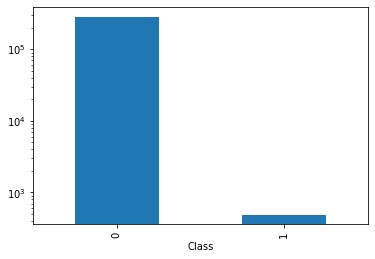

In [8]:
counts.plot(kind='bar', x='Class', y='n', logy=True, legend=False)

<AxesSubplot:>

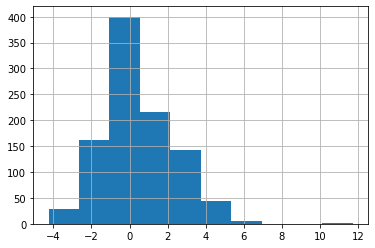

In [9]:
sample_data.V4.hist()

In [10]:
%%bigquery --project {PROJECT}

SELECT ML_use, Class, COUNT(*) as n
FROM vertex_eu.creditcards_ml
GROUP BY ML_use, Class

Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.40rows/s]


,ML_use,Class,n
0,TEST,0.0,53405
1,TEST,1.0,90
2,UNASSIGNED,0.0,230910
3,UNASSIGNED,1.0,402


# Generate Schema


The [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) data schema will be used in:
1. Identify the raw data types and shapes in the data transformation.
2. Create the serving input signature for the custom model.
3. Validate the new raw training data in the TFX pipeline.

In [11]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=sample_data,
    stats_options=tfdv.StatsOptions(
        label_feature='Class',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [12]:
tfdv.visualize_statistics(stats)

In [13]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'V1',FLOAT,required,,-
'V2',FLOAT,required,,-
'V3',FLOAT,required,,-
'V4',FLOAT,required,,-
'V5',FLOAT,required,,-
'V6',FLOAT,required,,-
'V7',FLOAT,required,,-
'V8',FLOAT,required,,-
'V9',FLOAT,required,,-


In [14]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

# Create Vertex Dataset

In [15]:
print("Project ID:", PROJECT)
print("Region:", REGION)

vertex_ai.init(
    project=PROJECT,
    location=REGION
)

Project ID: pbalm-cxb-aa
Region: europe-west1


In [16]:
bq_uri = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}"

dataset = vertex_ai.TabularDataset.create(
    display_name=VERTEX_DATASET_NAME, bq_source=bq_uri)

dataset.gca_resource

Creating TabularDataset
Create TabularDataset backing LRO: projects/188940921537/locations/europe-west1/datasets/6561920578939256832/operations/4081837962071900160
TabularDataset created. Resource name: projects/188940921537/locations/europe-west1/datasets/6561920578939256832
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/188940921537/locations/europe-west1/datasets/6561920578939256832')


name: "projects/188940921537/locations/europe-west1/datasets/6561920578939256832"
display_name: "creditcards"
metadata_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/metadata/tabular_1.0.0.yaml"
create_time {
  seconds: 1657135115
  nanos: 507803000
}
update_time {
  seconds: 1657135116
  nanos: 222519000
}
etag: "AMEw9yNnfx7hVSXqOezwDsBFMJ2B9BnyoZP-DGbL4RdqIWSUk24DiNG0wgKab8Zx3DM="
labels {
  key: "aiplatform.googleapis.com/dataset_metadata_schema"
  value: "TABLE"
}
metadata {
  struct_value {
    fields {
      key: "inputConfig"
      value {
        struct_value {
          fields {
            key: "bigquerySource"
            value {
              struct_value {
                fields {
                  key: "uri"
                  value {
                    string_value: "bq://pbalm-cxb-aa.vertex_eu.creditcards_ml"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}

## Retrieve and inspect the Dataset

In [17]:
dataset = vertex_ai.TabularDataset.list(
    filter=f"display_name={VERTEX_DATASET_NAME}", 
    order_by="update_time")[-1]

print("Dataset resource name:", dataset.resource_name)
print("Dataset BigQuery source:", dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri'])

Dataset resource name: projects/188940921537/locations/europe-west1/datasets/6561920578939256832
Dataset BigQuery source: bq://pbalm-cxb-aa.vertex_eu.creditcards_ml


# Build the TFX Pipeline

In [18]:
import tfx.v1 as tfx
from tfx.extensions.google_cloud_big_query.example_gen.component import BigQueryExampleGen
from tfx.proto import example_gen_pb2, transform_pb2

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_data_validation as tfdv
import tensorflow_model_analysis as tfma
from tensorflow_transform.tf_metadata import schema_utils


import ml_metadata as mlmd
from ml_metadata.proto import metadata_store_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

import logging
import json

from src.common import features, datasource_utils
from src.model_training import data
from src.tfx_pipelines import components

In [19]:
logging.getLogger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

print("TFX Version:", tfx.__version__)
print("Tensorflow Version:", tf.__version__)

TFX Version: 1.8.0
Tensorflow Version: 2.8.1


In [20]:
PARENT = f"projects/{PROJECT}/locations/{REGION}"
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

Project ID: pbalm-cxb-aa
Region: europe-west1
Bucket name: pbalm-cxb-aa-eu
Service Account: 188940921537-compute@developer.gserviceaccount.com
Vertex API Parent URI: projects/pbalm-cxb-aa/locations/europe-west1


## Create Interactive TFX Context

In [21]:
REMOVE_ARTIFACTS = True

if tf.io.gfile.exists(ARTIFACT_STORE) and REMOVE_ARTIFACTS:
    print("Removing previous artifacts...")
    tf.io.gfile.rmtree(ARTIFACT_STORE)
    
if tf.io.gfile.exists(MLMD_SQLLITE) and REMOVE_ARTIFACTS:
    print("Deleting previous mlmd.sqllite...")
    tf.io.gfile.rmtree(MLMD_SQLLITE)
    
print(f'Pipeline artifacts directory: {PIPELINE_ROOT}')
print(f'Local metadata SQLlit path: {MLMD_SQLLITE}')

Removing previous artifacts...
Deleting previous mlmd.sqllite...
Pipeline artifacts directory: gs://pbalm-cxb-aa-eu/creditcards/tfx_artifacts_interactive/creditcards-classifier-v03-train-pipeline
Local metadata SQLlit path: mlmd.sqllite


In [22]:
connection_config = metadata_store_pb2.ConnectionConfig()
connection_config.sqlite.filename_uri = MLMD_SQLLITE
connection_config.sqlite.connection_mode = 3 # READWRITE_OPENCREATE
mlmd_store = mlmd.metadata_store.MetadataStore(connection_config)

context = InteractiveContext(
  pipeline_name=PIPELINE_NAME,
  pipeline_root=PIPELINE_ROOT,
  metadata_connection_config=connection_config
)

### Pipeline step 1: Hyperparameter generation

In [23]:
batch_size = 512

hyperparams_gen = components.hyperparameters_gen(
    num_epochs=5,
    learning_rate=0.001,
    batch_size=batch_size,
    hidden_units='64,64',
    steps_per_epoch=LIMIT // batch_size
)

context.run(hyperparams_gen, enable_cache=False)

ExecutionResult(
    component_id: hyperparameters_gen
    execution_id: 1
    outputs:
        hyperparameters: OutputChannel(artifact_type=HyperParameters, producer_component_id=hyperparameters_gen, output_key=hyperparameters, additional_properties={}, additional_custom_properties={}))

#### Load the output of the component from Cloud Storage to check

In [24]:
gcs_uri_ouput = hyperparams_gen.outputs['hyperparameters'].get()[0].uri
gcs_uri_ouput

'gs://pbalm-cxb-aa-eu/creditcards/tfx_artifacts_interactive/creditcards-classifier-v03-train-pipeline/hyperparameters_gen/hyperparameters/1'

In [25]:
json.load(
    tf.io.gfile.GFile(
        os.path.join(gcs_uri_ouput, 'hyperparameters.json')
    )
)

{'num_epochs': 5,
 'steps_per_epoch': 9,
 'batch_size': 512,
 'learning_rate': 0.001,
 'hidden_units': [64, 64]}

### Pipeline Step 2: Extract data from BQ onto Cloud Storage

In [26]:
def sql_query(ml_use, limit=None):
    return datasource_utils.get_training_source_query(PROJECT, REGION, VERTEX_DATASET_NAME, ml_use=ml_use, limit=limit)

def output_config(splits):
    return example_gen_pb2.Output(
        split_config=example_gen_pb2.SplitConfig(
            splits=[example_gen_pb2.SplitConfig.Split(name=split_name, hash_buckets=buckets) for (split_name, buckets) in splits]
        )
    )

train_example_gen = BigQueryExampleGen(query=sql_query('UNASSIGNED', LIMIT), output_config=output_config([('train', 4), ('eval', 1)]))

beam_pipeline_args=[
    f"--project={PROJECT}",
    f"--temp_location={os.path.join(WORKSPACE, 'tmp')}"
]

context.run(
    train_example_gen,
    beam_pipeline_args=beam_pipeline_args,
    enable_cache=False
)

/opt/conda/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:2471: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


ExecutionResult(
    component_id: BigQueryExampleGen
    execution_id: 2
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=BigQueryExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

In [27]:
test_example_gen = BigQueryExampleGen(query=sql_query('TEST'), output_config=output_config([('test', 1)]))

context.run(
    test_example_gen,
    beam_pipeline_args=beam_pipeline_args,
    enable_cache=False
)

ExecutionResult(
    component_id: BigQueryExampleGen
    execution_id: 3
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=BigQueryExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

#### Read some TFRecords from the training data

In [28]:
import numpy as np

In [29]:
train_uri = os.path.join(train_example_gen.outputs['examples'].get()[0].uri, "Split-train/*")

source_raw_schema = tfdv.load_schema_text(os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt'))
raw_feature_spec = schema_utils.schema_as_feature_spec(source_raw_schema).feature_spec

In [30]:
def _parse_tf_example(tfrecord):
    return tf.io.parse_single_example(tfrecord, raw_feature_spec)

tfrecord_filenames = tf.data.Dataset.list_files(train_uri)
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
dataset = dataset.map(_parse_tf_example)

for raw_features in dataset.shuffle(1000).batch(3).take(1):
    for key in raw_features:
        print(f"{key}: {np.squeeze(raw_features[key], -1)}")
    print("")

2022-07-06 19:20:09.436020: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 19:20:09.437259: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Amount: [0. 0. 0.]
Class: [0. 0. 0.]
V1: [1.0461413 1.1997205 1.1689086]
V10: [0.3901947  0.55062634 0.44589236]
V11: [-1.1393745 -1.6296915 -1.139158 ]
V12: [-0.39482966 -0.5167969   0.131479  ]
V13: [-1.9218417  -1.0192152  -0.21300435]
V14: [-0.33374482 -0.02176614 -0.57454365]
V15: [-1.0697992  -0.75358224 -1.2944838 ]
V16: [-0.27680206  0.28570202  0.35821792]
V17: [ 0.49888453 -0.27236488 -0.49355382]
V18: [-0.6540888  -0.23921375  0.1401151 ]
V19: [-1.03557   -0.4207682 -0.1933326]
V2: [-0.03463715  0.33035874 -0.13998115]
V20: [-0.34086758 -0.23298466 -0.0671614 ]
V21: [ 0.04998136 -0.1265633  -0.03300349]
V22: [ 0.45581287 -0.20702814  0.1142178 ]
V23: [-0.03803961 -0.12559994 -0.1638628 ]
V24: [ 0.4089741 -0.1285437  1.045593 ]
V25: [0.44290787 0.6597566  0.7753427 ]
V26: [0.22821347 0.1125695  0.2287454 ]
V27: [0.05441242 0.00238787 0.05084648]
V28: [0.02316082 0.01235102 0.02001855]
V3: [ 1.5730032   0.6588915  -0.09551847]
V4: [2.956754  2.635943  1.7354262]
V5: [-0.947926

### Pipeline step 3: Data Validation

Import the schema, generate statistics and validate the statistics against the schema.

In [31]:
schema_importer = tfx.dsl.Importer(
    source_uri=RAW_SCHEMA_DIR,
    artifact_type=tfx.types.standard_artifacts.Schema,
    reimport=False
)

context.run(schema_importer)

ExecutionResult(
    component_id: Importer
    execution_id: 4
    outputs:
        result: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 4
        type_id: 18
        uri: "src/raw_schema"
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.8.0"
          }
        }
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

Generate statistics

In [32]:
statistics_gen = tfx.components.StatisticsGen(
    examples=train_example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 5
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [33]:
!rm -rf {RAW_SCHEMA_DIR}/.ipynb_checkpoints/

Validate statistics against schema

In [34]:
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_importer.outputs['result'],
)

context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 6
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}))

In [35]:
context.show(example_validator.outputs['anomalies'])

### Pipeline Step 4: Data Preprocesing using TFX Transform (TFT)

In [ ]:
_transform_module_file = 'src/preprocessing/transformations.py'

transform = tfx.components.Transform(
    examples=train_example_gen.outputs['examples'],
    schema=schema_importer.outputs['result'],
    module_file=_transform_module_file,
    splits_config=transform_pb2.SplitsConfig(
        analyze=['train'], transform=['train', 'eval']),
)

context.run(transform, enable_cache=False)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying etl.py -> build/lib
copying transformations.py -> build/lib
installing to /tmp/tmpr782ar_v
running install
running install_lib
copying build/lib/transformations.py -> /tmp/tmpr782ar_v
copying build/lib/etl.py -> /tmp/tmpr782ar_v
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /tmp/tmpr782ar_v/tfx_user_code_Transform-0.0+1489fc48aa34e31efd456312d719248746caa958987db631faf9759cca075a25-py3.7.egg-info
running inst

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


Processing /tmp/tmptaphjqlo/tfx_user_code_Transform-0.0+1489fc48aa34e31efd456312d719248746caa958987db631faf9759cca075a25-py3-none-any.whl
Processing /tmp/tmplab9ss8q/tfx_user_code_Transform-0.0+1489fc48aa34e31efd456312d719248746caa958987db631faf9759cca075a25-py3-none-any.whl
Processing /tmp/tmp56qdsfs_/tfx_user_code_Transform-0.0+1489fc48aa34e31efd456312d719248746caa958987db631faf9759cca075a25-py3-none-any.whl


2022-07-06 19:21:02.531765: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


#### Test: Read an example of the transformed data

In [ ]:
transformed_train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, "Split-train/*")
transform_graph_uri = transform.outputs['transform_graph'].get()[0].uri

tft_output = tft.TFTransformOutput(transform_graph_uri)
transform_feature_spec = tft_output.transformed_feature_spec()

for input_features, target in data.get_dataset(
    transformed_train_uri, transform_feature_spec, batch_size=3, epochs=1).take(1):
    for key in input_features:
        print(f"{key} ({input_features[key].dtype}): {input_features[key].numpy().tolist()}")
    print(f"target: {target.numpy().tolist()}")

### Pipeline Step 5: Model Training

In [ ]:
from tfx.dsl.components.common.resolver import Resolver
from tfx.dsl.experimental import latest_blessed_model_resolver

In [ ]:
_train_module_file = 'src/model_training/runner.py'

trainer = tfx.components.Trainer(
    module_file=_train_module_file,
    examples=transform.outputs['transformed_examples'],
    schema=schema_importer.outputs['result'],
    transform_graph=transform.outputs['transform_graph'],
    hyperparameters=hyperparams_gen.outputs['hyperparameters'],
)

context.run(trainer, enable_cache=False)

### Pipeline Step 6: Model Evaluation

#### Get the latest blessed model for model validation

In [ ]:
blessed_model_resolver = Resolver(
    strategy_class=latest_blessed_model_resolver.LatestBlessedModelResolver,
    model=tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
    model_blessing=tfx.dsl.Channel(type=tfx.types.standard_artifacts.ModelBlessing)
)

context.run(blessed_model_resolver, enable_cache=False)

#### Evaluate the model and compare against the baseline

In [ ]:
from tfx.components import Evaluator

In [ ]:
eval_config = tfma.EvalConfig(
    model_specs=[
        tfma.ModelSpec(
            signature_name='serving_tf_example',
            label_key=features.TARGET_FEATURE_NAME,
            prediction_key='probabilities')
    ],
    slicing_specs=[
        tfma.SlicingSpec(),
    ],
    metrics_specs=[
        tfma.MetricsSpec(
            metrics=[   
                tfma.MetricConfig(class_name='ExampleCount'),
                tfma.MetricConfig(
                    class_name='BinaryAccuracy',
                    threshold=tfma.MetricThreshold(
                        value_threshold=tfma.GenericValueThreshold(
                            lower_bound={'value': 0.1}), ## note setting a very low barrier for this example
                        # Change threshold will be ignored if there is no
                        # baseline model resolved from MLMD (first run).
                        change_threshold=tfma.GenericChangeThreshold(
                            direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                            absolute={'value': -1e-10}))),
        ])
    ])


evaluator = Evaluator(
    examples=test_example_gen.outputs['examples'],
    example_splits=['test'],
    model=trainer.outputs['model'],
    baseline_model=blessed_model_resolver.outputs['model'],
    eval_config=eval_config,
    schema=schema_importer.outputs['result']
)

context.run(evaluator, enable_cache=False)

In [ ]:
evaluation_results = evaluator.outputs['evaluation'].get()[0].uri
print("validation_ok:", tfma.load_validation_result(evaluation_results).validation_ok, '\n')

for entry in list(tfma.load_metrics(evaluation_results))[0].metric_keys_and_values:
    value = entry.value.double_value.value
    if value:
        print(entry.key.name, ":", round(entry.value.double_value.value, 3))

### Pipeline Step 7: Push model to Cloud Storage

In [ ]:
exported_model_location = os.path.join(MODEL_REGISTRY, MODEL_DISPLAY_NAME)

push_destination=tfx.proto.PushDestination(
    filesystem=tfx.proto.PushDestination.Filesystem(
        base_directory=exported_model_location,
    )
)

pusher = tfx.components.Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=push_destination
)

context.run(pusher, enable_cache=False)

### Pipeline Step 8: Upload model to Vertex AI

In [ ]:
serving_runtime = 'tf2-cpu.2-5'
serving_image_uri = f"us-docker.pkg.dev/vertex-ai/prediction/{serving_runtime}:latest"

labels = {
    'dataset_name': VERTEX_DATASET_NAME,
    'pipeline_name': PIPELINE_NAME
}
labels = json.dumps(labels)

vertex_model_uploader = components.vertex_model_uploader(
    project=PROJECT,
    region=REGION,
    model_display_name=MODEL_DISPLAY_NAME,
    pushed_model_location=exported_model_location,
    serving_image_uri=serving_image_uri,
    model_blessing=evaluator.outputs['blessing'],
    explanation_config='',
    labels=labels
)

context.run(vertex_model_uploader, enable_cache=False)

In [ ]:
vertex_model_uploader.outputs['uploaded_model'].get()[0].uri

## Unit Testing

In [ ]:
os.environ["VERTEX_DATASET_NAME"] = VERTEX_DATASET_NAME
os.environ["MODEL_DISPLAY_NAME"] =  MODEL_DISPLAY_NAME
os.environ["PIPELINE_NAME"] = PIPELINE_NAME
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["BQ_LOCATION"] = BQ_LOCATION
os.environ["BQ_DATASET_NAME"] = BQ_DATASET_NAME
os.environ["ML_TABLE"] = ML_TABLE
os.environ["GCS_LOCATION"] = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}/e2e_tests"
os.environ["TRAIN_LIMIT"] = "1000"
os.environ["TEST_LIMIT"] = "100"
os.environ["UPLOAD_MODEL"] = "1"
os.environ["ACCURACY_THRESHOLD"] = "-0.1"    # NB Negative accuracy threshold makes no sense - allows everything
os.environ["BEAM_RUNNER"] = "DirectRunner"
os.environ["TRAINING_RUNNER"] = "local"
os.environ["SUBNETWORK"] = DATAFLOW_SUBNETWORK

os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT


In [ ]:
from src.tfx_pipelines import config
import importlib
importlib.reload(config)

for key, value in config.__dict__.items():
    if key.isupper(): print(f'{key}: {value}')

In [ ]:
!python -m pytest src/tests/datasource_utils_tests.py -s

In [ ]:
!python -m pytest src/tests/model_tests.py -s

#### End to end pipeline unit test

In [ ]:
!python -m pytest src/tests/pipeline_deployment_tests.py::test_e2e_pipeline -s

## Deploy to Vertex AI Pipelines

In [ ]:
os.environ["VERTEX_DATASET_NAME"] = VERTEX_DATASET_NAME
os.environ["MODEL_DISPLAY_NAME"] = MODEL_DISPLAY_NAME
os.environ["PIPELINE_NAME"] = PIPELINE_NAME
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["GCS_LOCATION"] = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}"
os.environ["TRAIN_LIMIT"] = "85000"
os.environ["TEST_LIMIT"] = "15000"
os.environ["BEAM_RUNNER"] = "DataflowRunner"
os.environ["TRAINING_RUNNER"] = "vertex"
os.environ["TFX_IMAGE_URI"] = f"{REGION}-docker.pkg.dev/{PROJECT}/{VERTEX_DATASET_NAME}/vertex:latest"
os.environ["ENABLE_CACHE"] = "1"
os.environ["SUBNETWORK"] = DATAFLOW_SUBNETWORK
os.environ["SERVICE_ACCOUNT"] = DATAFLOW_SERVICE_ACCOUNT

In [ ]:
from src.tfx_pipelines import config
import importlib

importlib.reload(config)

for key, value in config.__dict__.items():
    if key.isupper(): print(f'{key}: {value}')

In [ ]:
config.BEAM_RUNNER

### Create Repo for Images

In [ ]:
!gcloud artifacts repositories create {VERTEX_DATASET_NAME} --location={REGION} --repository-format=docker

### Build Dataflow Worker Image

In [ ]:
!cp build/Dockerfile.dataflow Dockerfile
!echo gcloud builds submit . --tag {REGION}-docker.pkg.dev/{PROJECT}/{VERTEX_DATASET_NAME}/dataflow:latest --timeout=30m --machine-type=e2-highcpu-8

### Build Vertex worker image

In [ ]:
!echo $TFX_IMAGE_URI

In [ ]:
!cp build/Dockerfile.vertex Dockerfile
!echo gcloud builds submit --tag $TFX_IMAGE_URI . --timeout=15m --machine-type=e2-highcpu-8 --billing-project=$PROJECT --suppress-logs

### Compile the pipeline

In [ ]:
from src.tfx_pipelines import config, runner

pipeline_definition_file = f'{config.PIPELINE_NAME}.json'
pipeline_definition = runner.compile_training_pipeline(pipeline_definition_file)

In [ ]:
PIPELINES_STORE = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}/compiled_pipelines/"
!gsutil cp {pipeline_definition_file} {PIPELINES_STORE}

### Submit Vertex AI Pipelines run

In [ ]:
from google.cloud.aiplatform import pipeline_jobs
    
job = pipeline_jobs.PipelineJob(template_path = pipeline_definition_file,
                                display_name=VERTEX_DATASET_NAME,
                                enable_caching=False,
                                parameter_values={
                                    'learning_rate': 0.003,
                                    'batch_size': 512,
                                    'steps_per_epoch': int(config.TRAIN_LIMIT) // 512,
                                    'hidden_units': '128,128',
                                    'num_epochs': 30,
                                })

job.run(sync=False, service_account=DATAFLOW_SERVICE_ACCOUNT)